In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"

ROOT_PATH = "/workspace/modnet/"


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from input_pipeline import get_numpy_dataset
from ml_collections import ConfigDict
from modnet.modules.green_fn import GreenFunction
from modnet.solver import Solver
from rte_op import RTEOperator, RTEModel
import optax
from input_pipeline import create_tf_dataset


In [3]:
# original_ds = get_numpy_dataset(ROOT_PATH + "data/rte/rte_2d")

train_ds, test_ds, init_ds = create_tf_dataset(
    ROOT_PATH + "data/rte/rte_2d_converted",
    10,
    num_collocation_pts=500,
    test_batch_size=100,
)


Prepare numpy arrays for feeding into neural network.
Origin shapes: {'sigma': (500, 38, 38, 2), 'psi_bc': (500, 40, 12), 'psi_label': (500, 38, 38, 24), 'phi': (500, 38, 38), 'xy': (38, 38, 2), 'theta': (24, 1), 'omega': (24,), 'c': (24, 1), 's': (24, 1), 'bc_points': (40, 12, 4), 'bc_weights': (40, 12)}
cs shape: (24, 2)
Dataset is ready, shapes are: {'psi_label': (500, 34656), 'sigma': (500, 1444, 2), 'phi': (500, 1444), 'bc_psi': (500, 480)}


In [4]:
print(train_ds.element_spec)

print(test_ds.element_spec)

print(tf.nest.map_structure(lambda x: x.shape, init_ds))


{'interior': (TensorSpec(shape=(500, 2), dtype=tf.float32, name=None), TensorSpec(shape=(500, 2), dtype=tf.float32, name=None), GraphOfMapping(x=TensorSpec(shape=(1444, 2), dtype=tf.float32, name=None), fx=TensorSpec(shape=(None, 1444, 2), dtype=tf.float32, name=None)), GraphOfMapping(x=TensorSpec(shape=(480, 4), dtype=tf.float32, name=None), fx=TensorSpec(shape=(None, 480), dtype=tf.float32, name=None))), 'label': TensorSpec(shape=(None, 500), dtype=tf.float32, name=None)}
{'interior': (TensorSpec(shape=(34656, 2), dtype=tf.float32, name=None), TensorSpec(shape=(34656, 2), dtype=tf.float32, name=None), GraphOfMapping(x=TensorSpec(shape=(1444, 2), dtype=tf.float32, name=None), fx=TensorSpec(shape=(None, 1444, 2), dtype=tf.float32, name=None)), GraphOfMapping(x=TensorSpec(shape=(480, 4), dtype=tf.float32, name=None), fx=TensorSpec(shape=(None, 480), dtype=tf.float32, name=None))), 'label': TensorSpec(shape=(None, 34656), dtype=tf.float32, name=None)}
((2,), (2,), GraphOfMapping(x=(1444,

In [5]:
for data in test_ds.take(1).as_numpy_iterator():
    val_data = data

print(jax.tree_map(lambda x: x.shape, val_data))

{'interior': ((34656, 2), (34656, 2), GraphOfMapping(x=(1444, 2), fx=(100, 1444, 2)), GraphOfMapping(x=(480, 4), fx=(100, 480))), 'label': (100, 34656)}


In [6]:
config = ConfigDict(
    {
        "green_net": [128, 128, 128, 128, 1],
        "coeffs_net": {"weights": [64, 1], "coeffs": [64, 2]},
    }
)
sol = RTEOperator(config, GreenFunction)
eqn = RTEModel(name="lte")

solver = Solver(sol, eqn)

# opt = optax.adam(1e-3, eps=1e-7)

schedule_fn = optax.exponential_decay(-1e-3, 500, 0.96)
opt = optax.chain(
    optax.scale_by_adam(eps=1e-7), optax.scale_by_schedule(schedule_fn)
)

solver.compile(lambda x, y: jnp.mean(jnp.square(x - y)), opt, {"residual": 1})


In [7]:
import random
import sys

solver.solve(
    dataset=train_ds,
    init_data=init_ds,
    num_epochs=1000,
    val_data=(val_data["interior"], val_data["label"]),
    val_freq=20,
    seed=random.randrange(sys.maxsize),
)


Initializing parameters...
Parameters are: FlatMap({
  'greens_func/coeff_func/attension_net/linear': FlatMap({'weights': (4, 64)}),
  'greens_func/coeff_func/attension_net/linear_1': FlatMap({'weights': (64, 1)}),
  'greens_func/coeff_func/pointwise_mlp/linear': FlatMap({'bias': (64,), 'weights': (2, 64)}),
  'greens_func/coeff_func/pointwise_mlp/linear_1': FlatMap({'bias': (2,), 'weights': (64, 2)}),
  'greens_func/green_net/linear': FlatMap({'bias': (128,), 'weights': (10, 128)}),
  'greens_func/green_net/linear_1': FlatMap({'bias': (128,), 'weights': (128, 128)}),
  'greens_func/green_net/linear_2': FlatMap({'bias': (128,), 'weights': (128, 128)}),
  'greens_func/green_net/linear_3': FlatMap({'bias': (128,), 'weights': (128, 128)}),
  'greens_func/green_net/linear_4': FlatMap({'bias': (1,), 'weights': (128, 1)}),
})
Epoch 1/1000
40/40 [==============================] - 11s 92ms/step - rmse: 0.1891
Epoch 2/1000
40/40 [==============================] - 4s 88ms/step - rmse: 0.2136
Epo

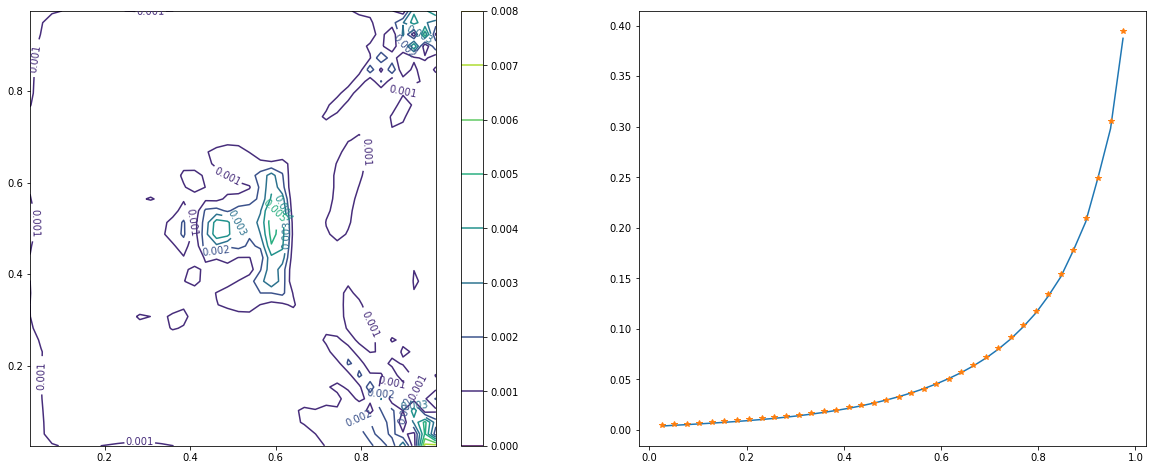

In [26]:
from modnet.typing import GraphOfMapping

idx = np.random.randint(500)

data_dict = np.load(ROOT_PATH + "data/rte/rte_2d_converted.npz")
list(data_dict.keys())

xy = data_dict["xy"].reshape(-1, 2)
sigma = data_dict["sigma"][idx : idx + 1].reshape(1, -1, 2)
bc_pts = data_dict["bc_points"].reshape(-1, 4)
bc_weights = (
    data_dict["psi_bc"][idx : idx + 1].reshape(1, -1)
    * data_dict["bc_weights"].flatten()
)
c, s, omega = data_dict["c"], data_dict["s"], data_dict["omega"]

phi = data_dict["phi"][idx]


# params = get_model_haiku_params("rte_2d_1", ROOT_PATH + "data/rte/")

pred_rho = sol.rho(
    solver.params,
    None,
    xy,
    GraphOfMapping(xy, sigma),
    GraphOfMapping(bc_pts, bc_weights),
    (np.concatenate([c, s], axis=-1), omega),
)

pred_rho = pred_rho.reshape(-1, 38, 38).squeeze()

import matplotlib.pyplot as plt


fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

cs = axs[0].contour(data_dict["xy"][..., 0], data_dict["xy"][..., 1], np.abs(pred_rho - phi))
axs[0].clabel(cs, inline=True, fontsize=10)
fig.colorbar(cs, ax=axs[0])

axs[1].plot(data_dict["xy"][:, 0, 0], phi[:, 0], data_dict["xy"][:, 0, 0], pred_rho[:, 0], "*")

plt.show()

In [12]:
from modnet.utils import to_flat_dict

np.savez(ROOT_PATH + "/data/rte/params/params_rte_2d_1.npz", **to_flat_dict(solver.params))